In [1]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [2]:
pd.set_option('mode.chained_assignment', None)
pd.options.mode.copy_on_write = True
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\ACCR-project-clj\accre-carbonara\notebooks


In [4]:
# def ce5_func():
    # read in dataset 
    # ce5 = pd.read_csv('../data/slurm_wrapper_ce5.log',
                      # header=None,
                      # delimiter=' - ',
                      # engine='python',
                    #   nrows=1000000
                      # )
    
    # set column names
    # colnames = ['END', 'USER', 'RETRY', 'TIME', 'RETURNCODE', 'COMMAND']
    # ce5.columns = colnames
    
    # Clean and convert other columns
    # ce5['TIME'] = ce5['TIME'].str.replace('time', '', regex=False).astype(float)
    # ce5['USER'] = ce5['USER'].str.replace('user', '', regex=False).astype(int)
    # ce5['RETRY'] = ce5['RETRY'].str.replace('retry', '', regex=False).astype(int)
    # ce5['RETURNCODE'] = ce5['RETURNCODE'].str.replace('returncode', '', regex=False).astype(float)
    # ce5['COMMAND'] = ce5['COMMAND'].str.replace('command', '', regex=False)
    # ce5['COMMAND'] = [re.sub("[\'\\[\\] ]", '', row).split(',') for row in ce5['COMMAND']];
    
    # slicing out the records that satisfy unresponsive conditions outlined. 
    # ce5_filtered = ce5[(ce5['USER'] == 9204) & (ce5['RETURNCODE'] == 1.0) & (ce5['TIME'] > 15)]
    # ce5_unresponsive_df = ce5_filtered[ce5_filtered['COMMAND'].map(lambda x: any('sbatch' in cmd for cmd in x))]
    # return ce5_unresponsive_df

In [5]:
# def ce6_func():
    # read in dataset 
    # ce6 = pd.read_csv('../data/slurm_wrapper_ce6.log',
                      # header=None,
                      # delimiter=' - ',
                      # engine='python',
                    #   nrows=10000
                      # )
    # set column names
    # colnames = ['END', 'USER', 'RETRY', 'TIME', 'RETURNCODE', 'COMMAND']
    # ce6.columns = colnames
    
    # Clean and convert other columns
    # ce6['TIME'] = ce6['TIME'].str.replace('time', '', regex=False).astype(float)
    # ce6['USER'] = ce6['USER'].str.replace('user', '', regex=False).astype(int)
    # ce6['RETRY'] = ce6['RETRY'].str.replace('retry', '', regex=False).astype(int)
    # ce6['RETURNCODE'] = ce6['RETURNCODE'].str.replace('returncode', '', regex=False).astype(float)
    # ce6['COMMAND'] = ce6['COMMAND'].str.replace('command', '', regex=False)
    # ce6['COMMAND'] = [re.sub("[\'\\[\\] ]", '', row).split(',') for row in ce6['COMMAND']];
    
    # slicing out the records that satisfy unresponsive conditions outlined. 
    # ce6_filtered = ce6[(ce6['USER'] == 9204) & (ce6['RETURNCODE'] == 1.0) & (ce6['TIME'] > 15)]
    # ce6_unresponsive_df = ce6_filtered[ce6_filtered['COMMAND'].map(lambda x: any('sbatch' in cmd for cmd in x))]
    # return ce6_unresponsive_df

In [6]:
def jobs_ce56_func():
    # Import data
    jobs = pd.read_csv("../data/fullsample.csv",
                    # nrows = 1000000
                    )
    ce5 = pd.read_csv('../data/ce5_unresponsive.csv') 
    ce6 = pd.read_csv('../data/ce6_unresponsive.csv')
    jobs = jobs[jobs['END'] != 'Unknown']
    
    # Convert dates to datetime objects
    jobs['END'] = pd.to_datetime(jobs['END'])
    jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'])
    
    # String manipulation of memory columns
    jobs['USEDMEM'] = jobs['USEDMEM'].str[:-1]
    jobs.insert(5, 'Mc_Mn', jobs['REQMEM'].str[-2:])
    jobs['REQMEM']  = jobs['REQMEM'].str[:-2]
    
    # Convert to numeric values for easier manipulation, and create difference col
    jobs['USEDMEM'] = pd.to_numeric(jobs['USEDMEM'])
    jobs['REQMEM'] = pd.to_numeric(jobs['REQMEM'])
    jobs['DIFFMEM'] = jobs['REQMEM'] - jobs['USEDMEM']
    
    # Create boolean column for status = COMPLETE, drop all rows where status is not complete
    jobs.insert(2, 'COMPLETE', jobs['STATE'] == 'COMPLETED')
    jobs['COMPLETE'] = jobs['COMPLETE'].astype(int)
    jobs = jobs.drop(columns=['STATE'])
    jobs = jobs[jobs['COMPLETE'] != 0]
    
    # Create columns to assign failure, job counts, and concat into one df
    ce56 = pd.concat([ce5, ce6])
    jobs['FAILED'] = 0
    jobs['JOBCOUNT'] = 1
    ce56['JOBCOUNT'] = 0
    ce56['FAILED'] = 1
    jobs_ce56 = pd.concat([jobs, ce56])
    
    # Broadened to 5 minute intervals in desired datetime column 'END' 
    jobs_ce56['END'] = pd.to_datetime(jobs_ce56['END']).dt.floor('5min')
    # ce56.to_csv('../data/ce56.csv', index=False)
    return jobs_ce56

In [7]:
jobs_ce56_func();

In [92]:
def reg_df_func():
    # Narrow down DataFrame to columns that matter
    df = jobs_ce56_func()[['END', 'JOBID', 'FAILED', 'JOBCOUNT', 'NODES', 'USEDMEM', 'CPUS', 'PARTITION']]
    
    # Create new DataFrame sorted by date with just dates where failed is none
    df1 = df[df['FAILED'] == 0]
    df1 = (
        df1
        .groupby('END')['FAILED']
        .value_counts()
        .reset_index()
    )
    
    # Create similar DataFrame sorted by date where failed has happened
    df2 = df[df['FAILED'] == 1]
    df2 = (
        df2
        .groupby('END')['FAILED']
        .value_counts()
        .reset_index()
    )
    
    # Concatenate both sorted dataframes and set the index to the END column
    reg_df = pd.merge(df1, df2, how='outer')
    reg_df = (
        reg_df
        .sort_values('END')
        .set_index('END')
    )
    
    # create new columns based on the count of slurm crashes and the frequency of completed jobs for any one time
    reg_df['slurm_crashes'] = reg_df[reg_df['FAILED'] == 1]['count']
    reg_df['completed_jobs'] = reg_df[reg_df['FAILED'] == 0]['count']
    reg_df = reg_df.drop(columns = ['count'])
    # reg_df.to_csv('../data/reg_df.csv', index=False)
    return reg_df

In [94]:
reg_df_func()

,FAILED,slurm_crashes,completed_jobs
END,,,
2020-10-01 00:10:00,0,NaN,3.00
2020-10-01 00:15:00,0,NaN,3.00
2020-10-01 00:20:00,0,NaN,9.00
2020-10-01 00:25:00,0,NaN,18.00
2020-10-01 00:30:00,0,NaN,11.00
...,...,...,...
2021-10-07 20:10:00,0,NaN,1.00
2021-10-07 20:15:00,0,NaN,1.00
2021-10-07 20:25:00,0,NaN,1.00


In [96]:
reg_df = reg_df_func()

In [97]:
# for index, row in reg_df.iterrows():
    # if row['FAILED'] == 1:
        # reg_df.at[index, 'completed_jobs'] = np.nan
    # if row['FAILED'] == 0:
        # reg_df.at[index, 'slurm_crashes'] = np.nan

In [98]:
# reg_df.sort_index(kind='mergesort')

In [99]:
reg_df[reg_df['FAILED'] == 1]

,FAILED,slurm_crashes,completed_jobs
END,,,
2020-10-18 06:15:00,1,1.00,4.00
2020-10-18 06:35:00,1,1.00,5.00
2020-10-18 06:50:00,1,2.00,60.00
2020-10-18 07:45:00,1,3.00,14.00
2020-10-18 07:50:00,1,1.00,7.00
...,...,...,...
2021-09-24 18:10:00,1,1.00,32.00
2021-09-24 19:10:00,1,1.00,26.00
2021-10-02 08:10:00,1,1.00,35.00


In [14]:
reg_df.sample(20)

,FAILED,slurm_crashes,completed_jobs
END,,,
2020-11-01 00:15:00,0,NaN,18.00
2021-01-01 20:35:00,0,NaN,36.00
2020-11-16 11:15:00,0,NaN,30.00
2021-05-02 12:15:00,0,NaN,179.00
2021-07-10 01:05:00,1,1.00,3.00
2020-10-21 10:25:00,0,NaN,35.00
2021-09-19 07:40:00,0,NaN,54.00
2021-09-01 10:55:00,0,NaN,164.00
2021-03-03 14:00:00,0,NaN,340.00


In [100]:
reg_df.loc['2020-10-18 07:45:00']

,FAILED,slurm_crashes,completed_jobs
END,,,
2020-10-18 07:45:00,0,3.00,14.00
2020-10-18 07:45:00,1,3.00,14.00


In [106]:
model = smf.logit('FAILED ~ completed_jobs',
                    data = reg_df).fit()

Optimization terminated successfully.
         Current function value: 0.101429
         Iterations 8


In [108]:
model.params

Intercept        -3.83
completed_jobs   -0.00
dtype: float64

In [110]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [112]:
jobs = 2

logit_p = model.params['Intercept'] + model.params['completed_jobs']*jobs

print(f'Estimated Probability: {logistic(logit_p)}')

Estimated Probability: 0.021192150189763868


In [115]:
slim_model = smf.logit('FAILED ~ 1', data = reg_df).fit()
full_model = smf.logit('FAILED ~ slurm_crashes + completed_jobs', data = reg_df).fit()

Optimization terminated successfully.
         Current function value: 0.102205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1


In [117]:
G2 = -2 * (slim_model.llf - full_model.llf)
G2

15788.218503282409

In [119]:
df3 = full_model.df_model - slim_model.df_model
df3

2.0

In [121]:
p = chi2.sf(G2, df = df3)
p

0.0

In [123]:
lm = smf.ols('completed_jobs ~ slurm_crashes', data = reg_df).fit()

In [147]:
jobs = 12

lm.params['Intercept'] + lm.params['slurm_crashes'] * jobs

4.214552956404816

In [129]:
reg_df['rolling'] = reg_df.rolling(7)['slurm_crashes'].sum()

In [137]:
reg_df.head()

,FAILED,slurm_crashes,completed_jobs,rolling,gage_shifted
END,,,,,
2020-10-01 00:10:00,0,NaN,3.00,NaN,NaN
2020-10-01 00:15:00,0,NaN,3.00,NaN,3.00
2020-10-01 00:20:00,0,NaN,9.00,NaN,3.00
2020-10-01 00:25:00,0,NaN,18.00,NaN,9.00
2020-10-01 00:30:00,0,NaN,11.00,NaN,18.00


In [133]:
new_lm = smf.ols('completed_jobs ~ rolling', data = reg_df).fit()

In [135]:
reg_df['gage_shifted'] = reg_df['completed_jobs'].shift(periods = 1)

In [141]:
shift_lm = smf.ols('completed_jobs ~ gage_shifted', data = reg_df).fit()

In [145]:
jobs = 12

shift_lm.params['Intercept'] + shift_lm.params['gage_shifted'] * jobs

25.564506569641804

In [149]:
sm.stats.anova_lm(lm)

,df,sum_sq,mean_sq,F,PR(>F)
slurm_crashes,1.00,144220.45,144220.45,11.06,0.00
Residual,4496.00,58608747.56,13035.75,NaN,NaN


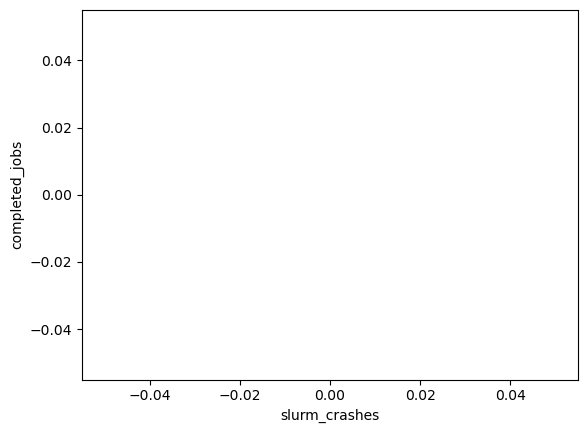

In [161]:
filtered_reg_df = reg_df.iloc[:len(lm.fittedvalues)]

filtered_reg_df.plot(x='slurm_crashes', y='completed_jobs', kind='scatter')
plt.plot(filtered_reg_df['slurm_crashes'], lm.fittedvalues, color='black')